In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

##### Video Inference Strong Scaling Bar Plot

In [9]:
csv_list = []
resources = [1, 2, 4, 8]

time_taken = []
tput = []

for i in resources:
    csv_list.append(pd.read_csv(f"_ALL [{i}x] g5.xlarge + [{i}x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv"))

for csv_file in csv_list:
    time_taken.append(csv_file.iloc[-1]['time_from_start'])
    tput.append(csv_file.iloc[-1]['number_of_rows_finished'] / csv_file.iloc[-1]['time_from_start'])


In [12]:
for csv_file in csv_list:
    print(csv_file.iloc[-1]['number_of_rows_finished'] / csv_file.iloc[-1]['time_from_start'])

21.35269331385775
45.784299676621806
91.33286087414686
183.3198477792353


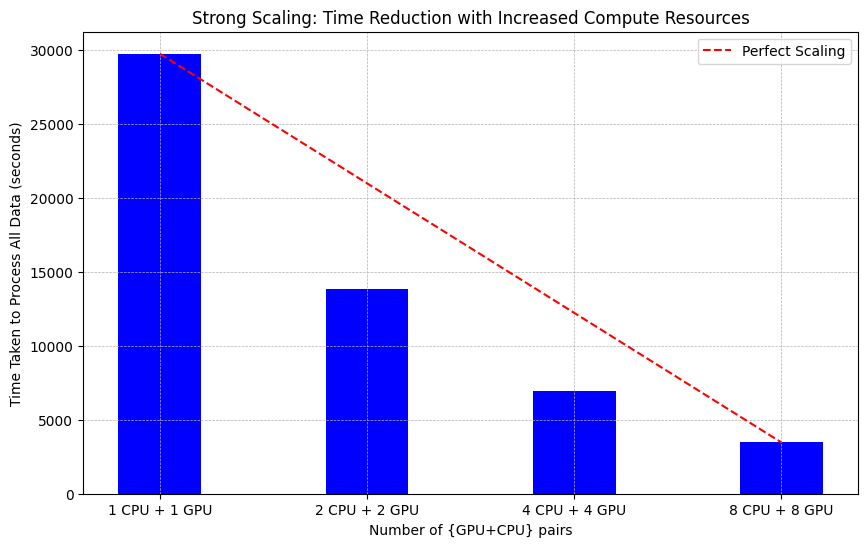

In [ ]:
resources_idx = np.arange(len(resources))

plt.figure(figsize=(10, 6))
plt.bar(resources_idx, time_taken, color='blue', width=0.4)
plt.plot([resources_idx[0], resources_idx[-1]], [time_taken[0], time_taken[-1]],
         linestyle='--', color='red', label='Perfect Scaling')

plt.xlabel('Number of {GPU+CPU} pairs')
plt.ylabel('Time Taken to Process All Data (seconds)')
plt.title('Strong Scaling: Time Reduction with Increased Compute Resources')
plt.xticks(resources_idx, [f"{x} CPU + {x} GPU" for x in resources])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


In [ ]:
# Adjusting the plot to place each bar side by side with equal distance on the x-axis
resources_idx = np.arange(len(resources))  # Use zero-based index for positioning bars

# Create a bar plot with a line to approximate the decrease
plt.figure(figsize=(8, 6))
plt.bar(resources_idx, time_taken, color='blue', label='Time Taken', width=0.4)

# Line plot for the decreasing trend
plt.plot(resources_idx, time_taken, marker='o', color='red', label='Trend')

plt.xlabel('Index of {GPU+CPU} pairs')
plt.ylabel('Time Taken to Process All Data (seconds)')
plt.title('Strong Scaling: Time Reduction with Increased Compute Resources')
plt.xticks(resources_idx, labels=resources)  # Label x-ticks with the number of resources
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


Single Node Tput Line Plot

In [ ]:
BATCH_SIZE = 32
INSTANCE_TYPE = "g5_xlarge"
data_local = pd.read_csv(f'video_inference_local_{INSTANCE_TYPE}_batch_{BATCH_SIZE}.csv')
data_s3_0_1 = pd.read_csv('[1x] g5.xlarge/video_inference_s3_g5_xlarge_batch_32.csv')
data_s3_1_1 = pd.read_csv('_ALL [1x] g5.xlarge + [1x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv')

In [7]:
data_s3_0_1.head()

,time_from_start,number_of_rows_finished
0,0.000000,0
1,27.537039,26
2,30.757921,52
3,34.483166,78
4,37.111850,104


In [8]:
def process(data, resample='60s'):
    data = data.copy()
    data['time_from_start'] = pd.to_timedelta(data['time_from_start'], unit='s')
    data.set_index('time_from_start', inplace=True)
    data['tput'] = data['number_of_rows_finished'].diff() / data.index.total_seconds().diff()
    data['tput'] = data['tput'].fillna(0)
    avg_tput = np.median(data['tput'])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data['tput'].resample(resample).median().bfill()
    idx = [str(item) for item in tput_resampled.index.to_pytimedelta()]
    return idx, tput_resampled.values, avg_tput

In [9]:
# idx_local, values_local, avg_local = process(data_local)
# idx_s3, values_s3, avg_s3 = process(data_s3)
idx_s3_0_1, values_s3_0_1, _ = process(data_s3_0_1)
idx_s3_1_1, values_s3_1_1, _ = process(data_s3_1_1)

avg_s3_0_1  = data_s3_0_1.iloc[-1]['number_of_rows_finished'] / data_s3_0_1.iloc[-1]['time_from_start']
avg_s3_1_1  = data_s3_1_1.iloc[-1]['number_of_rows_finished'] / data_s3_1_1.iloc[-1]['time_from_start']
avg_s3_0_1, avg_s3_1_1


(6.188258389698372, 21.35269331385775)

In [19]:
tput = []
with open('inference_tput.out', 'r') as f:
    for line in f:
        tput.append(float(line))
inference_tput_mean = np.mean(tput)

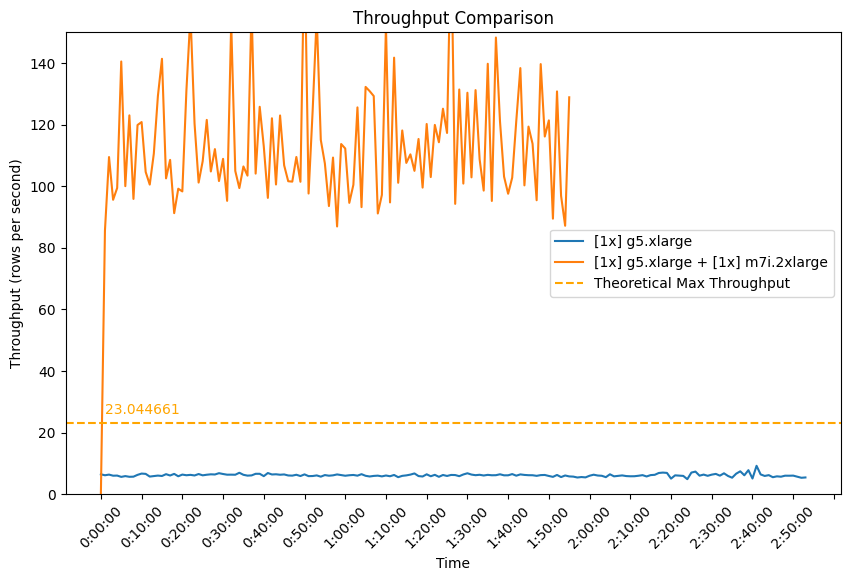

In [ ]:
plt.figure(figsize=(10, 6))

# plt.plot(idx_local, values_local)
# plt.plot(idx_s3, values_s3)
plt.plot(idx_s3_0_1, values_s3_0_1, label='[1x] g5.xlarge')
plt.plot(idx_s3_1_1, values_s3_1_1, label='[1x] g5.xlarge + [1x] m7i.2xlarge')

plt.axhline(y=inference_tput_mean, color='orange', linestyle='--', label='Theoretical Max Throughput')
# plt.axhline(y=avg_local, color='blue', linestyle='--', label='Read from Local')
# plt.axhline(y=avg_s3, color='red', linestyle='--', label='Read from S3')

plt.text(1, inference_tput_mean + 3, f'{np.round(inference_tput_mean, 6)}', color='orange')
# plt.text(1, avg_local + 2, f'{np.round(avg_local, 6)}', color='blue')
# plt.text(1, avg_s3 + 1, f'{np.round(avg_s3, 6)}', color='red')

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))

plt.xlabel('Time')
plt.ylabel('Throughput (rows per second)')
plt.ylim(0, 150)
plt.title("Throughput Comparison")
plt.legend()
plt.show()

In [20]:
data = data_local

In [21]:
data['time_from_start'] = pd.to_timedelta(data['time_from_start'], unit='s')
data.set_index('time_from_start', inplace=True)
data.head()

,number_of_rows_finished
time_from_start,
0 days 00:00:00,0
0 days 00:00:24.065711737,64
0 days 00:00:26.937317610,128
0 days 00:00:34.137617826,192
0 days 00:00:38.946805239,256


In [23]:
data['tput'] = data['number_of_rows_finished'].diff() / data.index.total_seconds().diff()
data['tput'] = data['tput'].fillna(0)
data['tput']

time_from_start
0 days 00:00:00               0.000000
0 days 00:00:24.065711737     2.659385
0 days 00:00:26.937317610    22.287181
0 days 00:00:34.137617826     8.888518
0 days 00:00:38.946805239    13.307861
                               ...    
0 days 01:10:02.566852808    20.694870
0 days 01:10:08.862399578    10.165916
0 days 01:10:11.564971209    23.681148
0 days 01:10:14.180271149    24.471381
0 days 01:10:14.871382952    24.598046
Name: tput, Length: 840, dtype: float64

In [25]:
tput_resampled = data['tput'].resample('5s').mean().ffill()
tput_resampled

time_from_start
0 days 00:00:00     0.000000
0 days 00:00:05     0.000000
0 days 00:00:10     0.000000
0 days 00:00:15     0.000000
0 days 00:00:20     2.659385
                     ...    
0 days 01:09:50    15.294489
0 days 01:09:55    11.733092
0 days 01:10:00    20.694870
0 days 01:10:05    10.165916
0 days 01:10:10    24.250192
Freq: 5s, Name: tput, Length: 843, dtype: float64